In [36]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Load datasets
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")
tags = pd.read_csv("tags.csv")

# Filter implicit positive feedback
ratings = ratings[ratings["rating"] >= 4.0]
ratings["user_id"] = ratings["userId"].astype(str)
ratings["item_id"] = ratings["movieId"].astype(str)
movies["item_id"] = movies["movieId"].astype(str)
tags["item_id"] = tags["movieId"].astype(str)
tags["user_id"] = tags["userId"].astype(str)

# Merge genres and tags
tag_agg = tags.groupby("item_id")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies = movies.merge(tag_agg, on="item_id", how="left")
movies["genres"] = movies["genres"].fillna("").str.replace("|", " ")
movies["tag"] = movies["tag"].fillna("")
movies["features"] = (movies["genres"] + " " + movies["tag"]).str.strip()

# Filter movies only in ratings
rated_items = set(ratings["item_id"].unique())
movies = movies[movies["item_id"].isin(rated_items)].copy()

# Build feature tuples
item_feature_tuples = [
    (row["item_id"], row["features"].split()) for _, row in movies.iterrows()
]
all_features = set(f for _, feats in item_feature_tuples for f in feats)

# Fit dataset
dataset = Dataset()
dataset.fit(
    users=ratings["user_id"],
    items=ratings["item_id"],
    item_features=all_features
)

# Build interaction & item feature matrices
(interactions, _) = dataset.build_interactions(
    [(row["user_id"], row["item_id"]) for _, row in ratings.iterrows()]
)
item_features = dataset.build_item_features(item_feature_tuples)

# Train the model
model = LightFM(loss="warp", learning_rate=0.05)
model.fit(interactions, item_features=item_features, epochs=20, num_threads=4)

# Evaluation metrics
precision = precision_at_k(model, interactions, item_features=item_features, k=5).mean()
recall_10 = recall_at_k(model, interactions, item_features=item_features, k=10).mean()
recall_20 = recall_at_k(model, interactions, item_features=item_features, k=20).mean()
auc = auc_score(model, interactions, item_features=item_features).mean()

print(f"Precision@5: {precision:.4f}")
print(f"Recall@10: {recall_10:.4f}")
print(f"Recall@20: {recall_20:.4f}")
print(f"AUC: {auc:.4f}")

# Recommend top-N items for a user
def recommend(model, user_id_str, user_map, item_map, N=5):
    user_id = user_map[user_id_str]
    scores = model.predict(user_id, np.arange(len(item_map)), item_features=item_features)
    top_items = np.argsort(-scores)[:N]
    item_inv_map = {v: k for k, v in item_map.items()}
    return [item_inv_map[i] for i in top_items]

# Show recommendations
user_map, _, item_map, _ = dataset.mapping()
user_id = "1"
recommendations = recommend(model, user_id, user_map, item_map)
print(f"Top {len(recommendations)} recommendations for user {user_id}: {recommendations}")


<ipython-input-36-5517e0a2de41>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings["user_id"] = ratings["userId"].astype(str)
<ipython-input-36-5517e0a2de41>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings["item_id"] = ratings["movieId"].astype(str)


Precision@5: 0.4381
Recall@10: 0.0878
Recall@20: 0.1494
AUC: 0.9333
 Top 5 recommendations for user 1: ['356', '1', '2571', '318', '260']


<ipython-input-37-f53c29364d14>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings["user_id"] = ratings["userId"].astype(str)
<ipython-input-37-f53c29364d14>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings["item_id"] = ratings["movieId"].astype(str)


🎯 AUC: 0.9352
Precision@5: 0.4443 | Recall@5: 0.0506
Precision@10: 0.4140 | Recall@10: 0.0891
Precision@20: 0.3628 | Recall@20: 0.1466


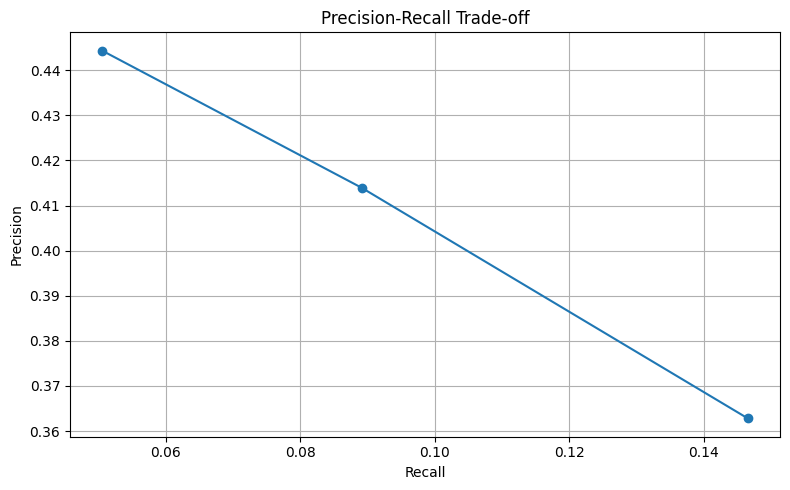

🔮 Recommendations for user 1: ['Toy Story (1995)', 'Forrest Gump (1994)', 'Jurassic Park (1993)', 'Aladdin (1992)', 'Matrix, The (1999)']
🔮 Recommendations for user 2: ['Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Matrix, The (1999)']
🔮 Recommendations for user 3: ['Species (1995)', 'Thing, The (1982)', '28 Weeks Later (2007)', 'Planet Terror (2007)', 'Iron Man (2008)']
🔮 Recommendations for user 4: ['Shawshank Redemption, The (1994)', "Schindler's List (1993)", 'Graduate, The (1967)', 'American Beauty (1999)', "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"]
🔮 Recommendations for user 5: ['Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', "Schindler's List (1993)", 'American Beauty (1999)']
🌍 Catalog coverage: 0.27%


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Load MovieLens data
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")
tags = pd.read_csv("tags.csv")

# Filter implicit feedback (rating >= 4)
ratings = ratings[ratings["rating"] >= 4.0]
ratings["user_id"] = ratings["userId"].astype(str)
ratings["item_id"] = ratings["movieId"].astype(str)
movies["item_id"] = movies["movieId"].astype(str)
tags["item_id"] = tags["movieId"].astype(str)
tags["user_id"] = tags["userId"].astype(str)

# Merge genres and tags into features
tag_agg = tags.groupby("item_id")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies = movies.merge(tag_agg, on="item_id", how="left")
movies["genres"] = movies["genres"].fillna("").str.replace("|", " ")
movies["tag"] = movies["tag"].fillna("")
movies["features"] = (movies["genres"] + " " + movies["tag"]).str.strip()

# Keep only items that are rated
rated_items = set(ratings["item_id"].unique())
movies = movies[movies["item_id"].isin(rated_items)].copy()

# Prepare item features
item_feature_tuples = [(row["item_id"], row["features"].split()) for _, row in movies.iterrows()]
all_features = set(f for _, feats in item_feature_tuples for f in feats)

# Fit dataset
dataset = Dataset()
dataset.fit(users=ratings["user_id"], items=ratings["item_id"], item_features=all_features)
(interactions, _) = dataset.build_interactions([(row["user_id"], row["item_id"]) for _, row in ratings.iterrows()])
item_features = dataset.build_item_features(item_feature_tuples)

# Train model
model = LightFM(loss="warp", learning_rate=0.05)
model.fit(interactions, item_features=item_features, epochs=20, num_threads=4)

# Evaluation metrics
ks = [5, 10, 20]
precisions = [precision_at_k(model, interactions, item_features=item_features, k=k).mean() for k in ks]
recalls = [recall_at_k(model, interactions, item_features=item_features, k=k).mean() for k in ks]
auc = auc_score(model, interactions, item_features=item_features).mean()

# Print scores
print(f"🎯 AUC: {auc:.4f}")
for k, p, r in zip(ks, precisions, recalls):
    print(f"Precision@{k}: {p:.4f} | Recall@{k}: {r:.4f}")

# Precision-Recall plot
plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, marker='o')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Trade-off")
plt.grid(True)
plt.tight_layout()
plt.show()

# Top-N recommendation function
def recommend(model, user_id_str, user_map, item_map, N=5):
    user_id = user_map[user_id_str]
    scores = model.predict(user_id, np.arange(len(item_map)), item_features=item_features)
    top_items = np.argsort(-scores)[:N]
    item_inv_map = {v: k for k, v in item_map.items()}
    return [item_inv_map[i] for i in top_items]

# Recommend for multiple users
user_map, _, item_map, _ = dataset.mapping()
sample_users = list(user_map.keys())[:5]
recommendations_by_user = {}

for uid in sample_users:
    recs = recommend(model, uid, user_map, item_map, N=5)
    titles = movies[movies["item_id"].isin(recs)][["title"]].title.tolist()
    recommendations_by_user[uid] = titles

# Print recommendations
for uid, recs in recommendations_by_user.items():
    print(f"🔮 Recommendations for user {uid}: {recs}")

# Catalog coverage
all_recommended_items = {item for recs in recommendations_by_user.values() for item in recs}
coverage = len(all_recommended_items) / len(movies)
print(f"🌍 Catalog coverage: {coverage:.2%}")
